# Step 1: Import Data
Here we are working with real life data: monthly sales of Spare Parts.<br>
Note that the location and the actual id numbers are confidential. <br>
The dataset has one column with the product id, and 24 more columns representing one month each. <br>
Then, we have a product and 23 consecutive months of sales after applying two months moving average (qty). <br>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

# Import data - sales of 24 months in the location X
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Import data - the sales as they are, and the sales with a 2 months moving average 
df_normal = pd.read_csv("drive/MyDrive/Time Series - Normal.csv", sep=";", index_col="Product id").head(800)
df_ma = pd.read_csv("drive/MyDrive/Time Series - Two Moving Average.csv", sep=";", index_col="Product id").head(800)

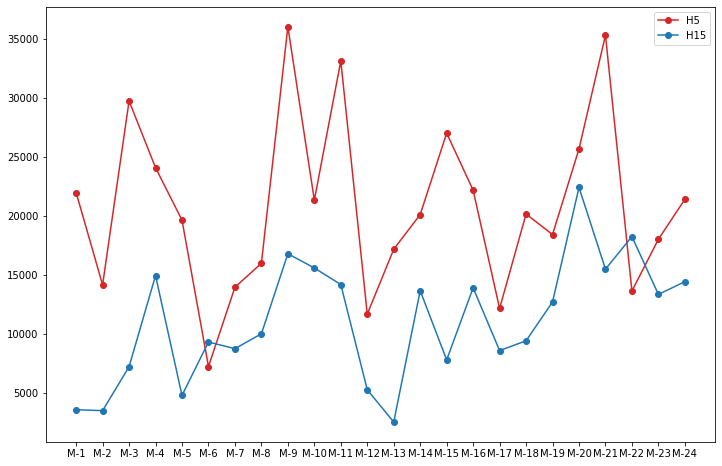

In [ ]:
# Select normal sales
x = df_normal.loc["H5"]
y = df_normal.loc["H15"]

plt.figure(figsize=(12, 8))
plt.plot(x, "-o", c="C3")
plt.plot(y, "-o", c="C0")
plt.legend([x.name, y.name]);

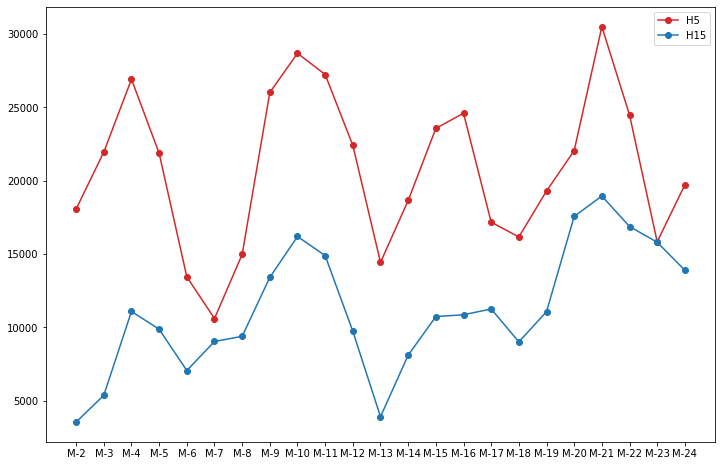

In [ ]:
# Select moving average sales
w = df_ma.loc["H5"]
z = df_ma.loc["H15"]

plt.figure(figsize=(12, 8))
plt.plot(w, "-o", c="C3")
plt.plot(z, "-o", c="C0")
plt.legend([w.name, z.name]);

# Step 2: Preprocessing
The data is structured, it was collected by a ERP system, <br>
therefore we don't need imputation techniques. <br>
On the other hand, the scale of the time series vary significantly, <br>
and we are interested on grouping the time series according to the patterns, <br>
therefore, we need to scale and will use two different techniques for this purpose: <br>
1. Z-Score Normalization <br>
2. MinMax Normalization <br>

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardizing (z-score normalization) a dataset involves rescaling the distribution of values 
# so the mean of observed values is 0 and the standard deviation is 1. 
# Taken from https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/
ss = StandardScaler()
scaled_ss = ss.fit_transform(df_ma.T)
df_ss = pd.DataFrame(scaled_ss.T, columns=df_ma.columns, index=df_ma.index)
X_ss = df_ss.values
df_ss.head()

,M-2,M-3,M-4,M-5,M-6,M-7,M-8,M-9,M-10,M-11,M-12,M-13,M-14,M-15,M-16,M-17,M-18,M-19,M-20,M-21,M-22,M-23,M-24
Product id,,,,,,,,,,,,,,,,,,,,,,,
H1,-0.612694,-0.108346,1.302493,0.875335,0.039361,-0.069037,0.232095,2.306424,1.104519,-1.482259,-2.001139,-1.570883,-0.263915,0.873905,1.272237,0.488438,-0.281783,0.013631,-0.033778,-0.488334,-0.669871,-1.168024,0.241624
H2,1.456412,0.637713,-0.223525,0.241721,-0.310709,-1.576941,-1.004040,-0.415169,-1.049410,-0.504603,0.223500,1.129019,-0.156522,-1.566487,-1.609462,-0.665396,1.118421,0.688600,-0.352522,0.264950,0.281138,1.125607,2.267706
H3,-0.879257,0.247805,0.211639,-0.099650,0.843259,-0.128067,-1.133898,-1.143862,-1.061749,-0.480873,-0.572212,-0.029901,2.359663,2.362062,0.820194,-0.113489,-0.926495,0.127312,1.144584,0.829789,-0.217744,-1.173939,-0.985173
H4,-0.631485,0.540501,0.633385,0.217909,-0.200072,0.369302,0.354276,-0.141109,-0.662902,-2.237843,-1.793909,-0.264044,1.234404,0.970775,-1.374562,-0.288631,1.514424,2.003434,0.662070,-0.447082,0.775444,-0.449814,-0.784472
H5,-0.531453,0.221490,1.183886,0.204827,-1.428164,-1.978824,-1.130939,1.008729,1.527031,1.245888,0.309844,-1.236537,-0.418879,0.534603,0.734368,-0.705447,-0.900755,-0.293905,0.241060,1.878314,0.711504,-0.964695,-0.211946


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalization is a rescaling of the data from the original range so that all values are within the range of 0 and 1.
# Taken from https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/
mm = MinMaxScaler()
scaled_mm = mm.fit_transform(df_ma.T)
df_mm = pd.DataFrame(scaled_mm.T, columns=df_ma.columns, index=df_ma.index)
X_mm = df_mm.values
df_mm.head()

,M-2,M-3,M-4,M-5,M-6,M-7,M-8,M-9,M-10,M-11,M-12,M-13,M-14,M-15,M-16,M-17,M-18,M-19,M-20,M-21,M-22,M-23,M-24
Product id,,,,,,,,,,,,,,,,,,,,,,,
H1,0.322327,0.439412,0.766938,0.667773,0.473702,0.448537,0.518445,1.000000,0.720978,0.120458,0.000000,0.099884,0.403296,0.667441,0.759914,0.577955,0.399148,0.467729,0.456723,0.351197,0.309054,0.193407,0.520657
H2,0.790751,0.579592,0.357461,0.477457,0.334975,0.008388,0.156151,0.308032,0.144449,0.284965,0.472758,0.706310,0.374743,0.011084,0.000000,0.243494,0.703576,0.592717,0.324190,0.483449,0.487624,0.705430,1.000000
H3,0.083338,0.402077,0.391849,0.303815,0.570474,0.295778,0.011324,0.008506,0.031728,0.196003,0.170172,0.323540,0.999322,1.000000,0.563951,0.299901,0.069979,0.368001,0.655691,0.566665,0.270417,0.000000,0.053384
H4,0.378744,0.655072,0.676973,0.579012,0.480462,0.614707,0.611165,0.494364,0.371337,0.000000,0.104670,0.465378,0.818680,0.756522,0.203543,0.459581,0.884702,1.000000,0.683736,0.422222,0.710467,0.421578,0.342673
H5,0.375245,0.570453,0.819963,0.566133,0.142764,0.000000,0.219822,0.774552,0.908927,0.836038,0.593359,0.192445,0.404431,0.651630,0.703421,0.330135,0.279500,0.436831,0.575526,1.000000,0.697493,0.262923,0.458080


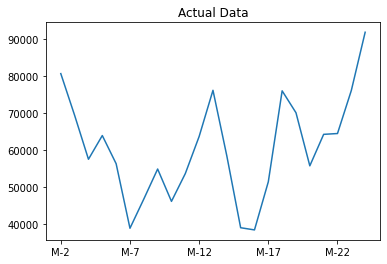

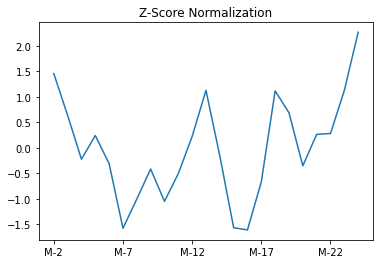

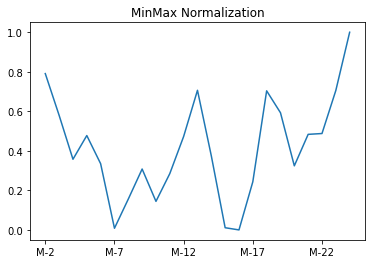

In [ ]:
# Select a product Id to compare normal data with scaled data
product = "H2"

# Visualize the sales (qty) for the product
df_ma.loc[product].plot(title="Actual Data"), plt.show()
df_ss.loc[product].plot(title="Z-Score Normalization"), plt.show()
df_mm.loc[product].plot(title="MinMax Normalization"), plt.show();

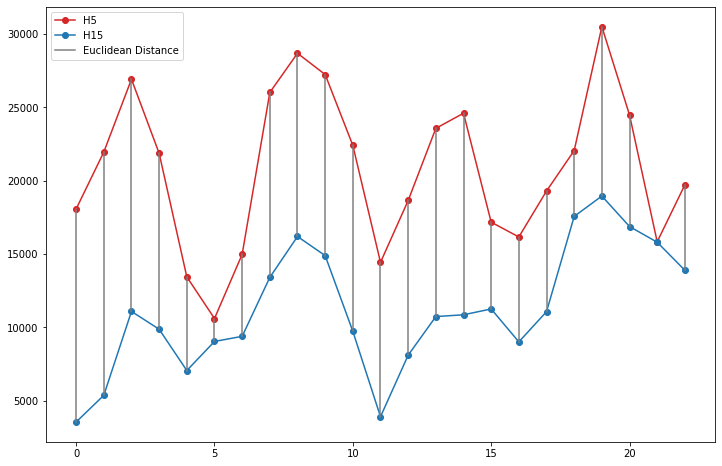

In [ ]:
# Graphic representation of Euclidean Distance -One to One Match
plt.figure(figsize=(12, 8))
plt.plot(np.arange(w.shape[0]), w, "-o", c="C3")
plt.plot(np.arange(z.shape[0]), z, "-o", c="C0")
for i, (x_i, y_j) in enumerate(zip(w,  z)):
    plt.plot([i, i], [x_i, y_j], c="C7")
plt.legend([w.name, z.name, "Euclidean Distance"]);

In [ ]:
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as dist

def dp(dist_mat):
    """
    Find minimum-cost path through matrix `dist_mat` using dynamic programming.

    The cost of a path is defined as the sum of the matrix entries on that
    path. See the following for details of the algorithm:

    - http://en.wikipedia.org/wiki/Dynamic_time_warping
    - https://www.ee.columbia.edu/~dpwe/resources/matlab/dtw/dp.m

    The notation in the first reference was followed, while Dan Ellis's code
    (second reference) was used to check for correctness. Returns a list of
    path indices and the cost matrix.
    """

    N, M = dist_mat.shape
    
    # Initialize the cost matrix
    cost_mat = np.zeros((N + 1, M + 1))
    for i in range(1, N + 1):
        cost_mat[i, 0] = np.inf
    for i in range(1, M + 1):
        cost_mat[0, i] = np.inf

    # Fill the cost matrix while keeping traceback information
    traceback_mat = np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            penalty = [
                cost_mat[i, j],      # match (0)
                cost_mat[i, j + 1],  # insertion (1)
                cost_mat[i + 1, j]]  # deletion (2)
            i_penalty = np.argmin(penalty)
            cost_mat[i + 1, j + 1] = dist_mat[i, j] + penalty[i_penalty]
            traceback_mat[i, j] = i_penalty

    # Traceback from bottom right
    i = N - 1
    j = M - 1
    path = [(i, j)]
    while i > 0 or j > 0:
        tb_type = traceback_mat[i, j]
        if tb_type == 0:
            # Match
            i = i - 1
            j = j - 1
        elif tb_type == 1:
            # Insertion
            i = i - 1
        elif tb_type == 2:
            # Deletion
            j = j - 1
        path.append((i, j))

    # Strip infinity edges from cost_mat before returning
    cost_mat = cost_mat[1:, 1:]
    return (path[::-1], cost_mat)

In [ ]:
# Distance matrix
N = w.shape[0]
M = z.shape[0]
dist_mat = np.zeros((N, M))
for i in range(N):
    for j in range(M):
        dist_mat[i, j] = abs(x[i] - y[j])

Alignment cost: 194767.0000
Normalized alignment cost: 4234.0652


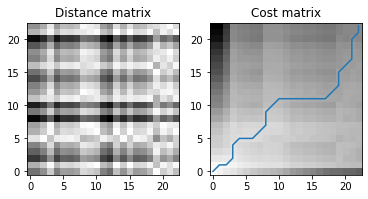

In [ ]:
# DTW
path, cost_mat = dp(dist_mat)
print("Alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]))
print("Normalized alignment cost: {:.4f}".format(cost_mat[N - 1, M - 1]/(N + M)))

plt.figure(figsize=(6, 4))
plt.subplot(121)
plt.title("Distance matrix")
plt.imshow(dist_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
plt.subplot(122)
plt.title("Cost matrix")
plt.imshow(cost_mat, cmap=plt.cm.binary, interpolation="nearest", origin="lower")
x_path, y_path = zip(*path)
plt.plot(y_path, x_path);

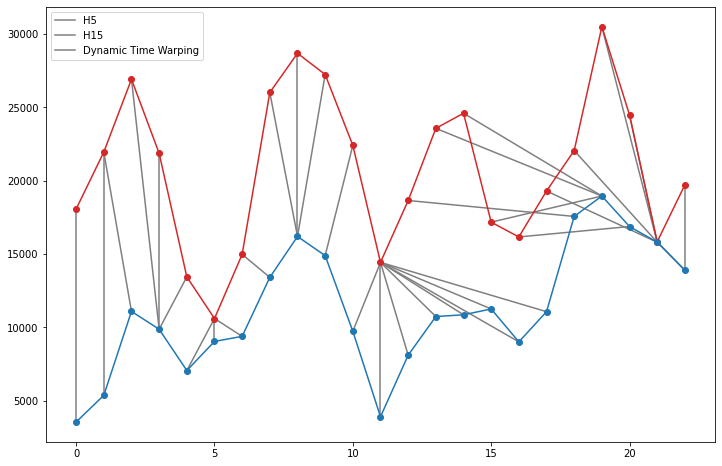

In [ ]:
plt.figure(figsize=(12, 8))
for x_i, y_j in path:
    plt.plot([x_i, y_j], [w[x_i], z[y_j]], c="C7")
plt.plot(np.arange(w.shape[0]), w, "-o", c="C3")
plt.plot(np.arange(z.shape[0]), z, "-o", c="C0")
plt.legend([w.name, z.name, "Dynamic Time Warping"]);

# Step 3: Use Tslearn to Calculate K-Means with DTW, Soft-DTW, and ED with its Silhouette Score.
We run the algorithm in parallel using the two different scaled datasets (Step 2). <br>
The idea is to cluster them under different parameters to find the combination with the best performance.

In [ ]:
try:
  from tslearn.clustering import TimeSeriesKMeans
  from tslearn.clustering import silhouette_score
except:
  import sys
  !{sys.executable} -m pip install tslearn
  from tslearn.clustering import TimeSeriesKMeans
  from tslearn.clustering import silhouette_score

import time

In [ ]:
# Experiment number 1. (1/2)
silhoutte_score_ss = []

for i in range(2, 10):

  start = time.time()

  km = TimeSeriesKMeans(n_clusters=i, metric="dtw", max_iter=20, max_iter_barycenter=10, random_state=0)
  y_pred_ss = km.fit_predict(X_ss)
  score_ss = silhouette_score(X_ss, y_pred_ss, metric="dtw")
  silhoutte_score_ss.append(score_ss)

  stop = time.time()
  duration = stop - start

  print(f"K = {i}.", f"Took {duration:.2f} seconds to calculate.")

K = 2. Took 69.44 seconds to calculate.
K = 3. Took 72.91 seconds to calculate.
K = 4. Took 58.29 seconds to calculate.
K = 5. Took 63.45 seconds to calculate.
K = 6. Took 70.55 seconds to calculate.
K = 7. Took 68.91 seconds to calculate.
K = 8. Took 73.32 seconds to calculate.
K = 9. Took 65.78 seconds to calculate.


In [ ]:
# Experiment number 1. (2/2)
silhoutte_score_mm = []

for i in range(2, 10):

  start = time.time()

  km = TimeSeriesKMeans(n_clusters=i, metric="dtw", max_iter=20, max_iter_barycenter=10, random_state=0)
  y_pred_mm = km.fit_predict(X_mm)
  score_mm = silhouette_score(X_mm, y_pred_mm, metric="dtw")
  silhoutte_score_mm.append(score_mm)

  stop = time.time()
  duration = stop - start

  print(f"K = {i}.", f"Took {duration:.2f} seconds to calculate.")

K = 2. Took 57.51 seconds to calculate.
K = 3. Took 55.88 seconds to calculate.
K = 4. Took 62.42 seconds to calculate.
K = 5. Took 62.24 seconds to calculate.
K = 6. Took 64.10 seconds to calculate.
K = 7. Took 62.13 seconds to calculate.
K = 8. Took 69.70 seconds to calculate.
K = 9. Took 73.73 seconds to calculate.


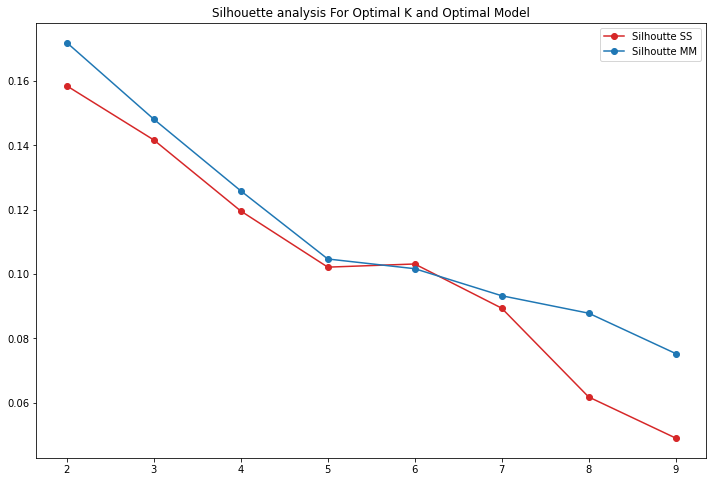

In [ ]:
# Experiment number 1.
plt.figure(figsize=(12, 8))
plt.plot(range(2, 10), silhoutte_score_ss, "-o", c="C3")
plt.plot(range(2, 10), silhoutte_score_mm, "-o", c="C0")
plt.title("Silhouette analysis For Optimal K and Optimal Model")
plt.legend(["Silhoutte SS", "Silhoutte MM"]);

In [ ]:
# Experiment number 2. (1/2)
silhoutte_score_ss = []

for i in range(2, 10):

  start = time.time()

  km = TimeSeriesKMeans(n_clusters=i, metric="softdtw", max_iter=20, max_iter_barycenter=10, random_state=0)
  y_pred_ss = km.fit_predict(X_ss)
  score_ss = silhouette_score(X_ss, y_pred_ss, metric="softdtw")
  silhoutte_score_ss.append(score_ss)

  stop = time.time()
  duration = stop - start

  print(f"K = {i}.", f"Took {duration:.2f} seconds to calculate.")

K = 2. Took 102.48 seconds to calculate.
K = 3. Took 109.21 seconds to calculate.
K = 4. Took 112.33 seconds to calculate.
K = 5. Took 115.67 seconds to calculate.
K = 6. Took 119.90 seconds to calculate.
K = 7. Took 123.57 seconds to calculate.
K = 8. Took 126.96 seconds to calculate.
K = 9. Took 131.89 seconds to calculate.


In [ ]:
# Experiment number 2. (2/2)
silhoutte_score_mm = []

for i in range(2, 10):

  start = time.time()

  km = TimeSeriesKMeans(n_clusters=i, metric="softdtw", max_iter=20, max_iter_barycenter=10, random_state=0)
  y_pred_mm = km.fit_predict(X_mm)
  score_mm = silhouette_score(X_mm, y_pred_mm, metric="softdtw")
  silhoutte_score_mm.append(score_mm)

  stop = time.time()
  duration = stop - start

  print(f"K = {i}.", f"Took {duration:.2f} seconds to calculate.")

K = 2. Took 86.98 seconds to calculate.
K = 3. Took 100.77 seconds to calculate.
K = 4. Took 103.02 seconds to calculate.
K = 5. Took 108.36 seconds to calculate.
K = 6. Took 105.13 seconds to calculate.
K = 7. Took 117.38 seconds to calculate.
K = 8. Took 124.08 seconds to calculate.
K = 9. Took 126.61 seconds to calculate.


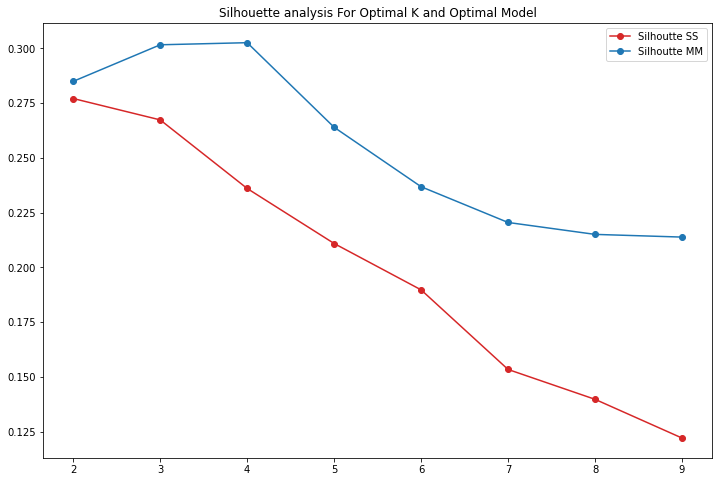

In [ ]:
# Experiment number 2.
plt.figure(figsize=(12, 8))
plt.plot(range(2, 10), silhoutte_score_ss, "-o", c="C3")
plt.plot(range(2, 10), silhoutte_score_mm, "-o", c="C0")
plt.title("Silhouette analysis For Optimal K and Optimal Model")
plt.legend(["Silhoutte SS", "Silhoutte MM"]);

In [ ]:
# Experiment number 3. (1/2)
silhoutte_score_ss = []

for i in range(2, 10):

  start = time.time()

  km = TimeSeriesKMeans(n_clusters=i, metric="euclidean", max_iter=20, max_iter_barycenter=10, random_state=0)
  y_pred_ss = km.fit_predict(X_ss)
  score_ss = silhouette_score(X_ss, y_pred_ss, metric="euclidean")
  silhoutte_score_ss.append(score_ss)

  stop = time.time()
  duration = stop - start

  print(f"K = {i}.", f"Took {duration:.2f} seconds to calculate.")

K = 2. Took 0.38 seconds to calculate.
K = 3. Took 0.44 seconds to calculate.
K = 4. Took 0.58 seconds to calculate.
K = 5. Took 0.60 seconds to calculate.
K = 6. Took 0.63 seconds to calculate.
K = 7. Took 0.60 seconds to calculate.
K = 8. Took 0.58 seconds to calculate.
K = 9. Took 0.63 seconds to calculate.


In [ ]:
# Experiment number 3. (2/2)
silhoutte_score_mm = []

for i in range(2, 10):

  start = time.time()

  km = TimeSeriesKMeans(n_clusters=i, metric="euclidean", max_iter=20, max_iter_barycenter=10, random_state=0)
  y_pred_mm = km.fit_predict(X_mm)
  score_mm = silhouette_score(X_mm, y_pred_mm, metric="euclidean")
  silhoutte_score_mm.append(score_mm)

  stop = time.time()
  duration = stop - start

  print(f"K = {i}.", f"Took {duration:.2f} seconds to calculate.")

K = 2. Took 0.36 seconds to calculate.
K = 3. Took 0.50 seconds to calculate.
K = 4. Took 0.60 seconds to calculate.
K = 5. Took 0.59 seconds to calculate.
K = 6. Took 0.60 seconds to calculate.
K = 7. Took 0.62 seconds to calculate.
K = 8. Took 0.56 seconds to calculate.
K = 9. Took 0.62 seconds to calculate.


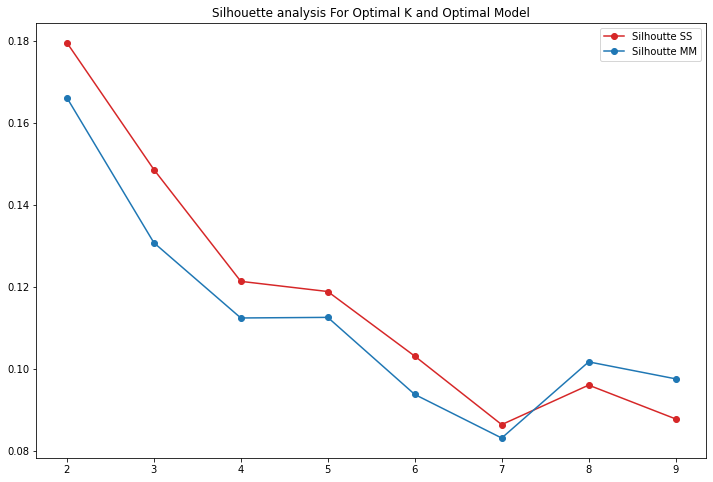

In [ ]:
# Experiment number 3.
plt.figure(figsize=(12, 8))
plt.plot(range(2, 10), silhoutte_score_ss, "-o", c="C3")
plt.plot(range(2, 10), silhoutte_score_mm, "-o", c="C0")
plt.title("Silhouette analysis For Optimal K and Optimal Model")
plt.legend(["Silhoutte SS", "Silhoutte MM"]);

# Step 4: Run K-Means with the normalization technique and parameters with the higher Silhouette Score
After identifying the best combination, we run one more time K-Means. <br>
The goal is to have a deeper look on the clusters suggested by the best combination. <br>
This should allow us to have a better discussion on the results of this implementation. <br>
Cluster one: Strongly seasonal (summer) <br>
Cluster two: Increasing sales <br>
Cluster three: Stable sales <br>
Cluster four: Decreasing sales <br>


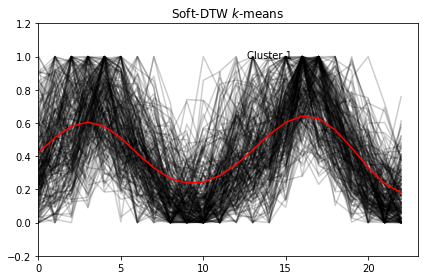

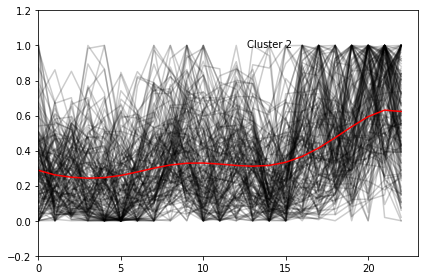

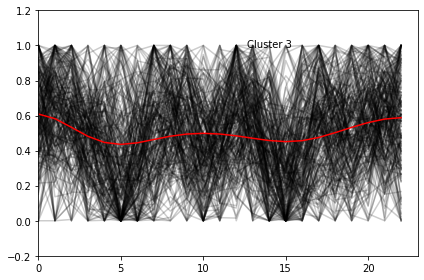

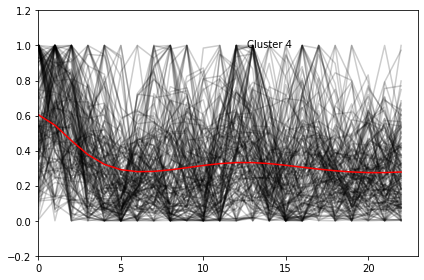

In [ ]:
# Based on the Silhoutte Score the best K = , the best metric is , and the best tecnique to normalize is MinMax
km = TimeSeriesKMeans(n_clusters=4, metric="softdtw", max_iter=20, max_iter_barycenter=10, random_state=0)
y_pred_mm = km.fit_predict(X_mm)

for yi in range(len(np.unique(y_pred_mm))):
  for xx in X_mm[y_pred_mm == yi]:
    plt.plot(xx.ravel(), "k-", alpha=.2)
  plt.plot(km.cluster_centers_[yi].ravel(), "r-")
  plt.xlim(0, X_mm.shape[1])
  plt.ylim(-0.2, 1.2)
  plt.text(0.55, 0.85,'Cluster %d' % (yi + 1), transform=plt.gca().transAxes)
  if yi == 0:
    plt.title("Soft-DTW $k$-means")

  plt.tight_layout()
  plt.show();

In [ ]:
for i in range(len(np.unique(y_pred_mm))):
  count = (sum(y_pred_mm == i)/len(y_pred_mm))*100
  print(f"The {count:.2f}% of the observations fall into Cluster {i + 1}")

The 28.50% of the observations fall into Cluster 1
The 21.50% of the observations fall into Cluster 2
The 29.12% of the observations fall into Cluster 3
The 20.88% of the observations fall into Cluster 4
